imports

In [0]:
import numpy as np
import tensorflow as tf
import math 
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn import preprocessing

parameters

In [0]:
# Duration of simulated trajectories (seconds)
T = 15

# Width and height of environment, or diameter for circular environment (meters)
L = 220

# Perimeter region distance to walls (meters)
d = 3

# Forward velocity Rayleigh distribution scale (m/sec)
forward_v_sigma = 13.02

# Rotation velocity Guassian distribution mean (deg/sec)
mu = -0.03 

# Rotation velocity Guassian distribution standard deviation (deg/sec)
angular_v_sigma = 330.12

# Velocity reduction factor when located in the perimeter 
v_reduction_factor = 0.25

# Change in angle when located in the perimeter (deg)
angle_delta = 90

# Simulation-step time increment (seconds)
dt = 0.02

# Number of place cells
N = 256

# Place cell standard deviation parameter (meters)
pc_std = 0.01

# Number of target head direction cells
M = 12

# Head direction concentration parameter 
K = 20

# Gradient clipping threshold
g_c = 10**-5

# Number of trajectories used in the calculation of a stochastic gradient
minibatch_size = 10

# Number of time steps in the trajectories used for the supervised learning task
trajectory_length = 100

# Step size multiplier in the RMSProp algorithm
learning_rate = 10**-5

# Momentum parameter of the RMSProp algorithm
momentum = 0.9

# Regularisation parameter for linear layer
L2_reg = 10**-5

# Total number of gradient descent steps taken
parameter_updates = 300000

rat trajectory generation

pseudo code https://ibb.co/VNvwC7Y

In [0]:
def rotation(vector,theta,pivot):
    """Rotates 3-D vector around y-axis"""
    R = np.array([[np.cos(theta),0,np.sin(theta)],pivot,[-np.sin(theta), 0, np.cos(theta)]])
    return np.dot(R,vector)

def angle(v1, v2):
    """The acute angle between two vectors"""
    angle = np.arctan2(v2[2], v2[0]) - np.arctan2(v1[2], v1[0])
    if angle > np.pi:
      angle -= 2*np.pi
    elif angle <= -np.pi:
      angle += 2*np.pi
    return angle

def min_dist_angle_y(position, direction):
    """Distance to the closest wall and its corresponding angle

    Keyword arguments:
    position -- the position (3-dimensional vector)
    direction -- head direction (3-dimensional vector)
    """
    
    # Perpendicular distance to line 
    # Southern Wall z = 0
    s_dist = position[2]
    # Northern Wall z = L
    n_dist = L - position[2]
    # Western Wall x = 0
    w_dist = position[0]
    # Eastern Wall x = L
    e_dist = L - position[0]
    
    wall_dists = [s_dist, n_dist, w_dist, e_dist]
    
    min_pos = np.argmin(wall_dists)
    
    dWall = wall_dists[min_pos]
    
    west_wall = [-1, 0, 0]

    north_wall = [0, 0, 1]

    east_wall = [1, 0, 0]

    south_wall = [0, 0, -1]
    
    walls = [south_wall, north_wall, west_wall, east_wall]
    aWall = angle(direction, walls[min_pos])
    return [dWall, aWall]

def min_dist_angle_z(position, direction):
    """Distance to the closest wall and its corresponding angle

    Keyword arguments:
    position -- the position (3-dimensional vector)
    direction -- head direction (3-dimensional vector)
    """
    
    # Perpendicular distance to line 
    # Southern Wall
    s_dist = position[1]
    # Northern Wall 
    n_dist = L - position[1]
    # Western Wall
    w_dist = position[0]
    # Eastern Wall
    e_dist = L - position[0]
    
    wall_dists = [s_dist, n_dist, w_dist, e_dist]
    
    min_pos = np.argmin(wall_dists)
    
    dWall = wall_dists[min_pos]
    
    west_wall = [-1, 0, 0]

    north_wall = [0, 1, 0]

    east_wall = [1, 0, 0]

    south_wall = [0, -1, 0]
    
    walls = [south_wall, north_wall, west_wall, east_wall]
    aWall = angle(direction, walls[min_pos])
    return [dWall, aWall]

def normalize(vec):
    return vec / np.linalg.norm(vec)

def generate_rat_trajectory(steps):
    """Generate a pseudo-random rat trajectory within a L-size square cage

    steps - number of steps for the rat to take
    
    return ->
      position - (samples,3)-shaped matrix holding the 3-dim positions overtime
      velocity - (samples,3)-shaped matrix holding the 3-dim velocities overtime
    """
    
    # Initialize parameters for velocity and camera
    v = 20
    dirr = normalize(np.random.rand(3))
    up = np.array([0, 1, 0])
    dt = 0.02

    # create random velocity samples
    random_turn_y = np.radians(np.random.normal(mu, angular_v_sigma, steps))
    random_turn_z = np.radians(np.random.normal(mu, angular_v_sigma, steps))
    # print(random_turn)
    random_velocity = np.random.rayleigh(forward_v_sigma, steps)
    
    # allocate memory for x, y, and z-components of position and velocity
    position_matrix = np.zeros((steps, 3))
    position_matrix[0] = L*np.random.rand(3) # initialize
    velocity_matrix = np.zeros((steps, 3))
    
    for step in range(1, steps):
        # computes the min distance and corresponding angle for a position
        [dWall_y, aWall_y] = min_dist_angle_y(position_matrix[step-1], dirr)
        [dWall_z, aWall_z] = min_dist_angle_z(position_matrix[step-1], dirr)

        # update speed and turn angle 
        close_to_wall_y = dWall_y<2 and np.absolute(aWall_y)<np.pi/2
        close_to_wall_z = dWall_z<2 and np.absolute(aWall_z)<np.pi/2

        if close_to_wall_y:
            angle_y = aWall_y/np.absolute(aWall_y)*(np.pi-np.absolute(aWall_y)) + random_turn_y[step]
        else:
            angle_y = random_turn_y[step]

        if close_to_wall_z:
            angle_z = aWall_z/np.absolute(aWall_z)*(np.pi-np.absolute(aWall_z)) + random_turn_z[step]
        else:
            angle_z = random_turn_z[step]

        if close_to_wall_y or close_to_wall_z:
          v = v-0.5*(v-v_reduction_factor) # slow down
        else:
          v = random_velocity[step]
        
        low = np.array([0,0,0])
        high = np.array([L,L,L])
        # move.
        position_matrix[step] = position_matrix[step-1] + dirr*v*dt #np.minimum(np.maximum(position_matrix[step-1] + dirr*v*dt, low), high)
        velocity_matrix[step] = dirr*v*dt
        
        # turn the 3D direction vector around y-axis
        dirr = rotation(dirr, angle_y*dt, [0,1,0])
        dirr = rotation(dirr, angle_z*dt, [0,0,1])
        
    # return init_pos, init_hd, ego_vel, target_pos, target_hd
    return [position_matrix/100.0 - 1.1, velocity_matrix/100.0]



example paths (15 seconds each)

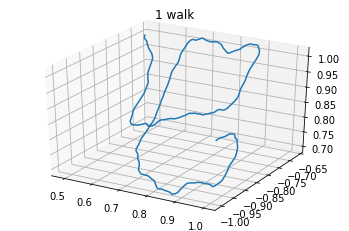

In [22]:
ax = plt.axes(projection='3d')
plt.title('1 walk')
[position_matrix, velocity_matrix] = generate_rat_trajectory(750) # 220 cm, 100 samples
ax.plot(position_matrix[:,0], position_matrix[:,1], position_matrix[:,2])

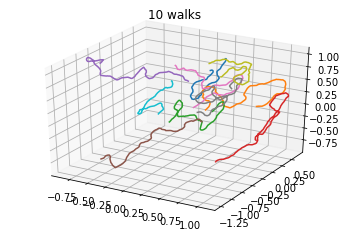

In [23]:
ax = plt.axes(projection='3d')
plt.title('10 walks')
for _ in range(10):
  [position_matrix, velocity_matrix] = generate_rat_trajectory(750) 
  ax.plot(position_matrix[:,0], position_matrix[:,1], position_matrix[:,2])

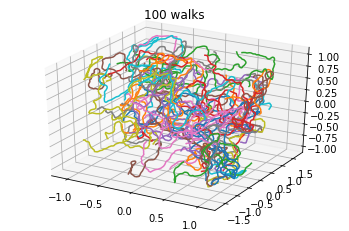

In [24]:
ax = plt.axes(projection='3d')
plt.title('100 walks')
for _ in range(100):
  [position_matrix, velocity_matrix] = generate_rat_trajectory(750) 
  ax.plot(position_matrix[:,0], position_matrix[:,1], position_matrix[:,2])

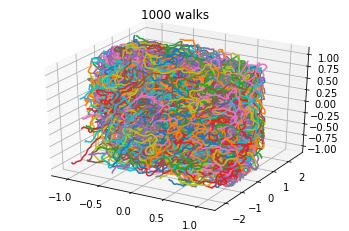

In [25]:
ax = plt.axes(projection='3d')
plt.title('1000 walks')
for _ in range(1000):
  [position_matrix, velocity_matrix] = generate_rat_trajectory(750) 
  ax.plot(position_matrix[:,0], position_matrix[:,1], position_matrix[:,2])

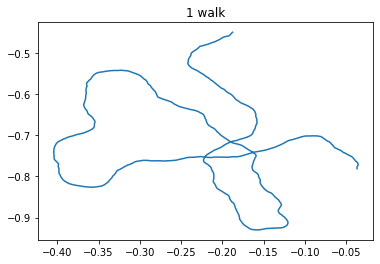

In [12]:
[position_matrix, velocity_matrix] = generate_rat_trajectory(800) # 220 cm, 100 samples
plt.plot(position_matrix[:,0], position_matrix[:,2])
plt.title('1 walk')
plt.show()

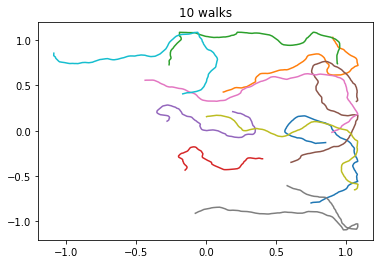

In [0]:
for _ in range(10):
  [position_matrix, velocity_matrix] = generate_rat_trajectory(750) # 15 seconds
  plt.plot(position_matrix[:,0], position_matrix[:,2])
plt.title('10 walks')
plt.show()

Average walk length (meters) 1.8074966394547667


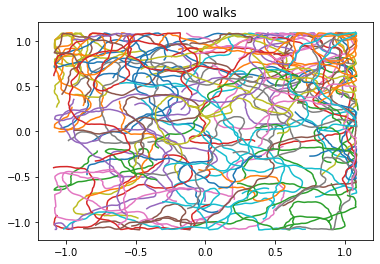

In [0]:
def sample(pos_matrix):
  return pos_matrix[[True if i%8==7 else False for i in range(len(pos_matrix))], :]

def path_length(sample):
  path_length = 0
  for i in range(len(sample)-1):
      path_length += np.sqrt(np.abs(sample[:,0][i]-sample[:,0][i+1])**2 + np.abs(sample[:,2][i]-sample[:,2][i+1])**2)
  return path_length

walk_lengths = []
for _ in range(100):
  [position_matrix, velocity_matrix] = generate_rat_trajectory(750) # 15 seconds
  walk_lengths.append(path_length(sample(position_matrix)))
  plt.plot(position_matrix[:,0], position_matrix[:,2])
print("Average walk length (meters)", np.mean(walk_lengths))
plt.title('100 walks')
plt.show()

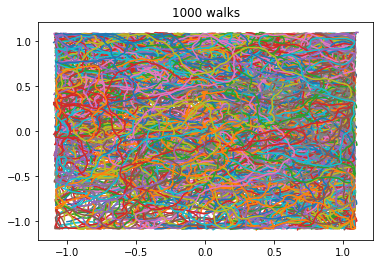

In [0]:
for _ in range(1000):
  [position_matrix, velocity_matrix] = generate_rat_trajectory(750) # 15 seconds
  plt.plot(position_matrix[:,0], position_matrix[:,2])
plt.title('1000 walks')
plt.show()

In [0]:
assert tf.__version__ == '1.15.0'

build dataset

In [0]:
from scipy import stats

def generate_rat_trajectory_for_dataset(steps, sample):
    """Generate a pseudo-random rat trajectory within a L-size square cage

    steps - number of steps for the rat to take
    
    return ->
      position - (samples,3)-shaped matrix holding the 3-dim positions overtime
      velocity - (samples,3)-shaped matrix holding the 3-dim velocities overtime
    """

    # record every steps/sample steps
    frequency = steps/sample
    
    # Initialize parameters for velocity and camera
    v = 20
    dirr = normalize(np.random.rand(3))
    up = np.array([0, 1, 0])
    dt = 0.02
    norm_vec = np.array([0,0,0])

    # create random velocity samples
    random_turn = np.radians(np.random.normal(mu, angular_v_sigma, steps))
    # print(random_turn)
    random_velocity = np.random.rayleigh(forward_v_sigma, steps)
    
    # allocate memory for x, y, and z-components of position and velocity
    hd = np.zeros(steps+1)
    hd[0] = angle(norm_vec, dirr)

    ego_vel = np.zeros((steps, 3))

    position_matrix = np.zeros((steps+1, 3))
    position_matrix[0] = L*np.random.rand(3) # initialize
    velocity_matrix = np.zeros((steps+1, 3))
    
    for step in range(1, steps+1):
        # computes the min distance and corresponding angle for a position
        [dWall, aWall] = min_dist_angle(position_matrix[step-1], dirr)

        # update speed and turn angle 
        if dWall<2 and np.absolute(aWall)<np.pi/2:
            # print('oups')
            angle_vel = aWall/np.absolute(aWall)*(np.pi-np.absolute(aWall)) + random_turn[step-1]
            v = v-0.5*(v-v_reduction_factor) # slow down
        else:
            v = random_velocity[step-1]
            angle_vel = random_turn[step-1]

        ego_vel[step-1][0] = v/100.0
        ego_vel[step-1][1] = angle_vel
        ego_vel[step-1][2] = angle_vel

        low = np.array([0,0,0])
        high = np.array([L,L,L])
        # move.
        position_matrix[step] = np.minimum(np.maximum(position_matrix[step-1] + dirr*v*dt, low), high)
        velocity_matrix[step] = dirr*v*dt
        
        # turn the 3D direction vector around y-axis
        dirr = y_rotation(dirr, angle_vel*dt)
        hd[step] = angle(norm_vec, dirr)

    index = [True if i%frequency==0 else False for i in range(steps)]
    position_matrix = np.delete(position_matrix, 1, 1)/100.0 - 1.1

    def bin_mean(arr):
      return stats.binned_statistic(np.arange(steps), arr, 'mean', bins=sample).statistic

    ego_vel = np.apply_along_axis(bin_mean, 0, ego_vel)

    ego_vel[:,1] = np.sin(ego_vel[:,1])
    ego_vel[:,2] = np.cos(ego_vel[:,2])

    velocity_matrix = velocity_matrix/100.0
    # return init_pos, init_hd, ego_vel, target_pos, target_hd
    return [position_matrix[0], 
            np.array([hd[0]]), 
            ego_vel, 
            position_matrix[1:][index, :], 
            hd[1:][index]]

In [0]:
from scipy import stats
values = [1,2,1,2,1,2,1,2,1,2,1,2,1,2,1,2]
stats.binned_statistic(np.arange(16), values, 'mean', bins=8).statistic

array([1.5, 1.5, 1.5, 1.5, 1.5, 1.5, 1.5, 1.5])

(2,)
(1,)
(100, 3)
(100, 2)
(100,)


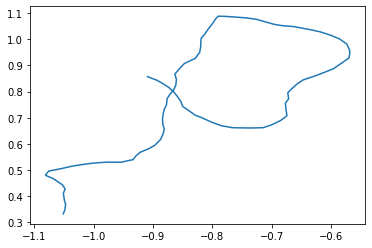

In [0]:
dataset_example = generate_rat_trajectory_for_dataset(800, 100)
for x in dataset_example:
  print(x.shape)
plt.plot(dataset_example[3][:,0], dataset_example[3][:,1])
plt.show()

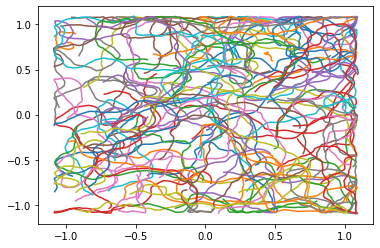

In [0]:
for _ in range(100):
  dataset_example = generate_rat_trajectory_for_dataset(800, 100)
  plt.plot(dataset_example[3][:,0], dataset_example[3][:,1])
plt.show()


In [0]:
"""
100 files

one file -> 10000 records

one record:
  init_pos : (2,)
  init_hd : (1,)
  ego_vel : (trajectory_length, 3) -- trajectory_length==100
  target_pos : (trajectory_length, 2)
  target_hd : (100, 1)
"""
import os

feature_map = {
        'init_pos':
            tf.FixedLenFeature(shape=[2], dtype=tf.float32),
        'init_hd':
            tf.FixedLenFeature(shape=[1], dtype=tf.float32),
        'ego_vel':
            tf.FixedLenFeature(
                shape=[100, 3],
                dtype=tf.float32),
        'target_pos':
            tf.FixedLenFeature(
                shape=[100, 2],
                dtype=tf.float32),
        'target_hd':
            tf.FixedLenFeature(
                shape=[100, 1],
                dtype=tf.float32),
    }

def filename_generator(root):
  """Generates lists of files for a given dataset version."""
  basepath = 'square_room_100steps_2.2m_1000000'
  base = os.path.join(root, basepath)
  num_files = 100
  template = '{:0%d}-of-{:0%d}.tfrecord' % (4, 4)
  return [
    os.path.join(base, template.format(i, num_files - 1))
    for i in range(num_files)
  ]

filenames = filename_generator('.')



In [0]:
data = []
for _ in range(100):
  record = generate_rat_trajectory_for_dataset(800, 100) # 15 seconds
  data.append(np.delete(position_matrix, 1, 1))
data = np.array(data)

In [0]:
for traj in data:
  plt.plot(traj[3][:,0], traj[3][:,1])
plt.show()

IndexError: ignored

In [0]:
def _float32_feature(value):
  return tf.train.Feature(float_list=tf.train.FloatList(value=value))

records_per_file = 100 #00
filename = './example.tfrecord'
tfrecord_writer = tf.python_io.TFRecordWriter(filename)

data = [generate_rat_trajectory_for_dataset(800, 100) for _ in range(100)]
  
for index in range(records_per_file):
  # 1. Convert your data into tf.train.Feature
  feature = {
    'init_pos': _float32_feature(data[index][0]),
    'init_hd': _float32_feature(data[index][1]),
    'ego_vel': _float32_feature([val for row in data[index][2] for val in row]), # flatten 
    'target_pos': _float32_feature([val for row in data[index][3] for val in row]), # flatten
    'target_hd': _float32_feature(data[index][4]) # flatten
  }
  # 2. Create a tf.train.Features
  features = tf.train.Features(feature=feature)
  # 3. Createan example protocol
  example = tf.train.Example(features=features)
  # 4. Serialize the Example to string
  example_to_string = example.SerializeToString()
  # 5. Write to TFRecord
  tfrecord_writer.write(example_to_string)

Encode position as place cell activations

In [0]:
# number of place cells
N = 5

# number of head direction cells
M = 4

#TODO figure out scalars
# place cell scale -- positive scalar fixed before experiment
SIGMA_c = 30

# head direction concentration parameter -- positive scalar fixed before experiment
K_h = 1

# uniform distribution of place cell centers  
PC_CENTERS = np.random.uniform(0,L,[N,2])

# uniform distribution of head direction cell centers  
HDC_CENTERS = np.random.uniform(-np.pi,np.pi,M)
'''
Place Cell Activations 
input
    x : vector in R^D
output
    c : vector in [0,1]^N
'''
def c(x):
    # assert x.shape[0] == 2
    # each top term -- note: np.array([x,]*N)-PC_CENTERS <=> x-PC_CENTERS
    iso_gaus_N = np.exp(-np.square(x-PC_CENTERS).sum(axis=1)/((2*SIGMA_c)**2))
    # print(iso_gaus_N)
    # normalize
    return iso_gaus_N/iso_gaus_N.sum()

'''
Head Direction Cell Activations 
input
    rho : scalar in R
output
    h : vector in [0,1]^M
'''
def h(rho):
    # each top term
    von_mises_M = np.exp(K_h*np.cos(rho-HDC_CENTERS))
    # normalize
    return von_mises_M/von_mises_M.sum()

In [0]:
import numpy as np
import matplotlib.pyplot as plt

for _ in range(100):
  [position_matrix, velocity_matrix] = generate_rat_trajectory(750) # 15 seconds
  # plt.plot(position_matrix[:,0], position_matrix[:,2])
  plt.scatter(position_matrix[:,0], position_matrix[:,2], c=-np.apply_along_axis(c, 0, np.array([position_matrix[:,0], position_matrix[:,2]]))[0], s=5)
plt.show()

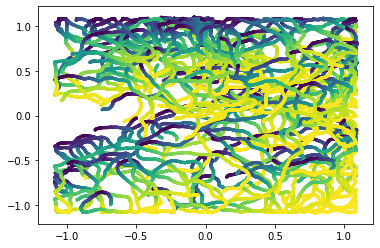

In [0]:
for _ in range(100):
  [position_matrix, velocity_matrix] = generate_rat_trajectory(750) # 15 seconds
  # plt.plot(position_matrix[:,0], position_matrix[:,2])
  plt.scatter(position_matrix[:,0], position_matrix[:,2], c=-np.apply_along_axis(c, 0, np.array([position_matrix[:,0], position_matrix[:,2]]))[1], s=5)
plt.show()

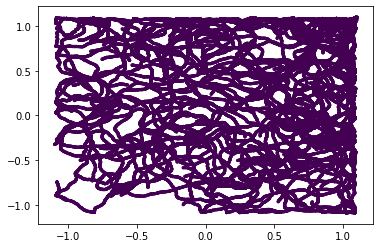

In [0]:
for _ in range(100):
  [position_matrix, velocity_matrix] = generate_rat_trajectory(750) # 15 seconds
  # plt.plot(position_matrix[:,0], position_matrix[:,2])
  plt.scatter(position_matrix[:,0], position_matrix[:,2], c=-np.apply_along_axis(c, 0, np.array([position_matrix[:,0], position_matrix[:,2]]))[2], s=5)
plt.show()

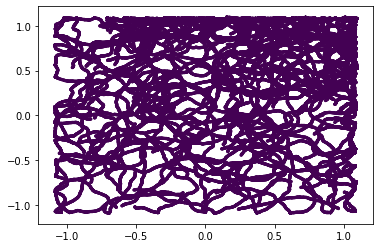

In [0]:
for _ in range(100):
  [position_matrix, velocity_matrix] = generate_rat_trajectory(750) # 15 seconds
  # plt.plot(position_matrix[:,0], position_matrix[:,2])
  plt.scatter(position_matrix[:,0], position_matrix[:,2], c=-np.apply_along_axis(c, 0, np.array([position_matrix[:,0], position_matrix[:,2]]))[3], s=5)
plt.show()

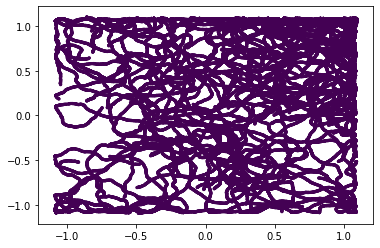

In [0]:
for _ in range(100):
  [position_matrix, velocity_matrix] = generate_rat_trajectory(750) # 15 seconds
  # plt.plot(position_matrix[:,0], position_matrix[:,2])
  plt.scatter(position_matrix[:,0], position_matrix[:,2], c=-np.apply_along_axis(c, 0, np.array([position_matrix[:,0], position_matrix[:,2]]))[4], s=5)
plt.show()

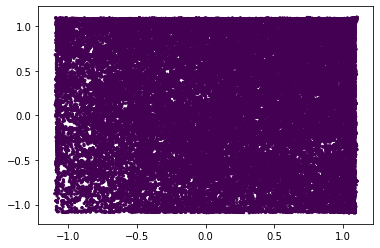

In [0]:
POS = generate_rat_trajectory(750)[0]
for _ in range(1000):
  [position_matrix, velocity_matrix] = generate_rat_trajectory(750) # 15 seconds
  POS = np.concatenate((POS, position_matrix), axis=0)
  # plt.plot(position_matrix[:,0], position_matrix[:,2])
  position_matrix = position_matrix[np.random.randint(position_matrix.shape[0], size=50), :]
  plt.scatter(position_matrix[:,0], position_matrix[:,2], c=-np.apply_along_axis(c, 0, np.array([position_matrix[:,0], position_matrix[:,2]]))[4], s=5)
plt.show()

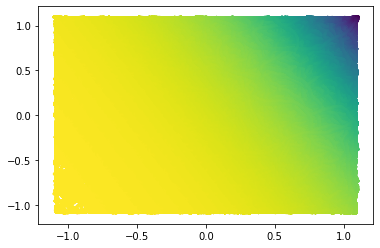

In [0]:
plt.scatter(POS[:,0], POS[:,2], c=-np.apply_along_axis(c, 0, np.array([POS[:,0], POS[:,2]]))[0], s=5)

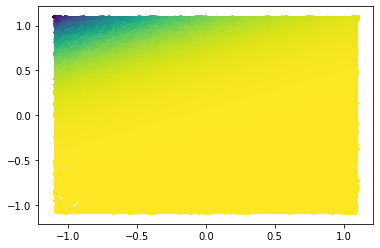

In [0]:
plt.scatter(POS[:,0], POS[:,2], c=-np.apply_along_axis(c, 0, np.array([POS[:,0], POS[:,2]]))[1], s=5)

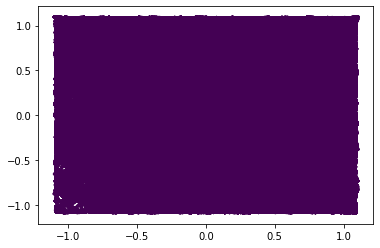

In [0]:
plt.scatter(POS[:,0], POS[:,2], c=-np.apply_along_axis(c, 0, np.array([POS[:,0], POS[:,2]]))[2], s=5)

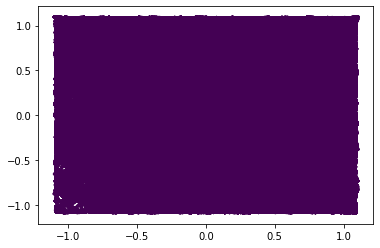

In [0]:
plt.scatter(POS[:,0], POS[:,2], c=-np.apply_along_axis(c, 0, np.array([POS[:,0], POS[:,2]]))[3], s=5)

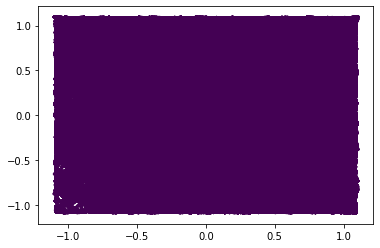

In [0]:
plt.scatter(POS[:,0], POS[:,2], c=-np.apply_along_axis(c, 0, np.array([POS[:,0], POS[:,2]]))[4], s=5)

In [0]:
import scipy.signal 

def calculate_ratemap(xs, ys, activations, statistic='mean'):
  return scipy.stats.binned_statistic_2d(
        xs,
        ys,
        activations,
        bins=20,
        statistic=statistic,
        range=((0, 220), (0, 220)))[0]

(-0.5, 19.5, 19.5, -0.5)

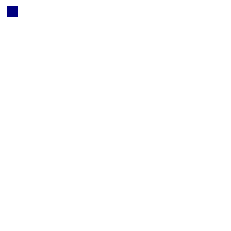

In [0]:
ratemap0 = calculate_ratemap(POS[:,0], POS[:,2], -np.apply_along_axis(c, 0, np.array([POS[:,0], POS[:,2]]))[0])
ax = plt.gca()
# Plot the ratemap
ax.imshow(ratemap0, interpolation='none', cmap='jet')
# ax.pcolormesh(ratemap, *args, **kwargs)
ax.axis('off')

(-0.5, 19.5, 19.5, -0.5)

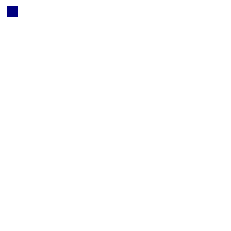

In [0]:
ratemap1 = calculate_ratemap(POS[:,0], POS[:,2], -np.apply_along_axis(c, 0, np.array([POS[:,0], POS[:,2]]))[1])
ax = plt.gca()
# Plot the ratemap
ax.imshow(ratemap1, interpolation='none', cmap='jet')
# ax.pcolormesh(ratemap, *args, **kwargs)
ax.axis('off')

(-0.5, 19.5, 19.5, -0.5)

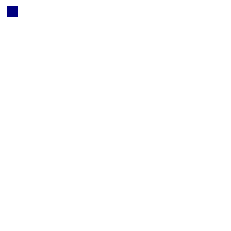

In [0]:
ratemap2 = calculate_ratemap(POS[:,0], POS[:,2], -np.apply_along_axis(c, 0, np.array([POS[:,0], POS[:,2]]))[2])
ax = plt.gca()
# Plot the ratemap
ax.imshow(ratemap2, interpolation='none', cmap='jet')
# ax.pcolormesh(ratemap, *args, **kwargs)
ax.axis('off')

(-0.5, 19.5, 19.5, -0.5)

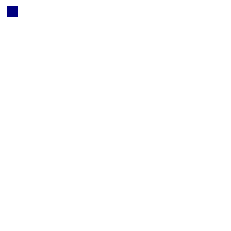

In [0]:
ratemap3 = calculate_ratemap(POS[:,0], POS[:,2], -np.apply_along_axis(c, 0, np.array([POS[:,0], POS[:,2]]))[3])
ax = plt.gca()
# Plot the ratemap
ax.imshow(ratemap3, interpolation='none', cmap='jet')
# ax.pcolormesh(ratemap, *args, **kwargs)
ax.axis('off')

(-0.5, 19.5, 19.5, -0.5)

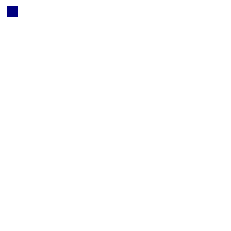

In [0]:
ratemap4 = calculate_ratemap(POS[:,0], POS[:,2], -np.apply_along_axis(c, 0, np.array([POS[:,0], POS[:,2]]))[4])
ax = plt.gca()
# Plot the ratemap
ax.imshow(ratemap4, interpolation='none', cmap='jet')
# ax.pcolormesh(ratemap, *args, **kwargs)
ax.axis('off')